# iPhone Health Data: XML to CSV

### Imports

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MaxAbsScaler

import matplotlib.pyplot as plt
import seaborn as sns

## Easy Transfer XML -> Pandas DF -> CSV

- larger files will take longer, but Pandas makes column sorting easier
- 1 GB ~ 1 min

In [ ]:
# with open('data/export.xml') as f:
#     data = ET.parse(f)
#     root = data.getroot()


In [ ]:
# records_df = pd.DataFrame([{**{'tag': child.tag}, **child.attrib} for child in root[2:]])
# records_df.to_csv('data/health_data.csv', index=False)

### Separate CSV just for workout data

In [ ]:
# workout_df = pd.DataFrame([{**{'tag': child.tag}, **child.attrib} for child in root[2:] if child.tag == 'Workout'])
# workout_df = workout_df.drop(columns=['tag'])
# workout_df.to_csv('data/workouts.csv', index=False)

### Separate CSV just for activity data

In [ ]:
# activity_df = pd.DataFrame([{**{'tag': child.tag}, **child.attrib} for child in root[2:] if child.tag == 'ActivitySummary'])
# activity_df = activity_df.drop(columns=['tag'])
# activity_df.to_csv('data/activity.csv', index=False)

### Get Specific Records from XML

In [15]:
# # 'type', 'startDate', 'endDate', 'value', 'unit'
# selected_columns = [1, 6, 7, 4, 8]

# selected_types = ['HKQuantityTypeIdentifierActiveEnergyBurned',
#                   'HKQuantityTypeIdentifierBasalEnergyBurned',
#                   'HKQuantityTypeIdentifierDistanceWalkingRunning']

# def float_handler(amount):
#     try:
#         return np.float64(amount)
#     except ValueError:
#         return np.nan


# records_df = pd.read_csv('data/health_data.csv', usecols=selected_columns,
#                         # parse_dates=['startDate', 'endDate'],
#                         # date_format='%Y-%m-%d %H:%M:%S %z',
#                         dtype={'type': 'string', 'unit': 'string',
#                                'startDate': 'string', 'endDate': 'string'},
#                         low_memory=False, index_col=False,
#                         converters={'value': float_handler}
#                         )[['type', 'startDate', 'endDate', 'value', 'unit']]

# records_df.head()

### Get daily sums for each data point

In [16]:
# selected_df = records_df.copy()
# selected_df = selected_df[selected_df['type'].isin(selected_types)].sort_values(by='startDate').reset_index(drop=True)

# # add simple date column
# selected_df['date'] = selected_df['startDate'].str[:10]

# # get daily sums
# sum_df = selected_df.groupby(by=['date', 'type', 'unit'])['value'].sum().reset_index()

# sum_df.to_csv('data/daily_sums.csv', index=False)

# sum_df

## Explore Data

In [18]:
sum_df = pd.read_csv('data/daily_sums.csv',
                     date_format='%Y-%m-%d',
                     parse_dates=['date'],
                     dtype={'date': 'string', 'type': 'string',
                            'unit': 'string', 'value': np.float64},
                     low_memory=False, index_col=False)

sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5258 entries, 0 to 5257
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5258 non-null   datetime64[ns]
 1   type    5258 non-null   string        
 2   unit    5258 non-null   string        
 3   value   5258 non-null   float64       
dtypes: datetime64[ns](1), float64(1), string(2)
memory usage: 164.4 KB


In [22]:
year_starts = ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01', '2025-01-01']

distance_travelled = sum_df[sum_df['type'] == 'HKQuantityTypeIdentifierDistanceWalkingRunning']
distance_travelled = distance_travelled.set_index('date')[['value']].rename(columns={'value': 'km'})

basal_energy = sum_df[sum_df['type'] == 'HKQuantityTypeIdentifierBasalEnergyBurned'].set_index('date')[['value']]
active_energy = sum_df[sum_df['type'] == 'HKQuantityTypeIdentifierActiveEnergyBurned'].set_index('date')[['value']]
total_cals = basal_energy.add(active_energy, fill_value=0).rename(columns={'value': 'calories'})[1:]
total_cals = total_cals[total_cals['calories'] > 1300]

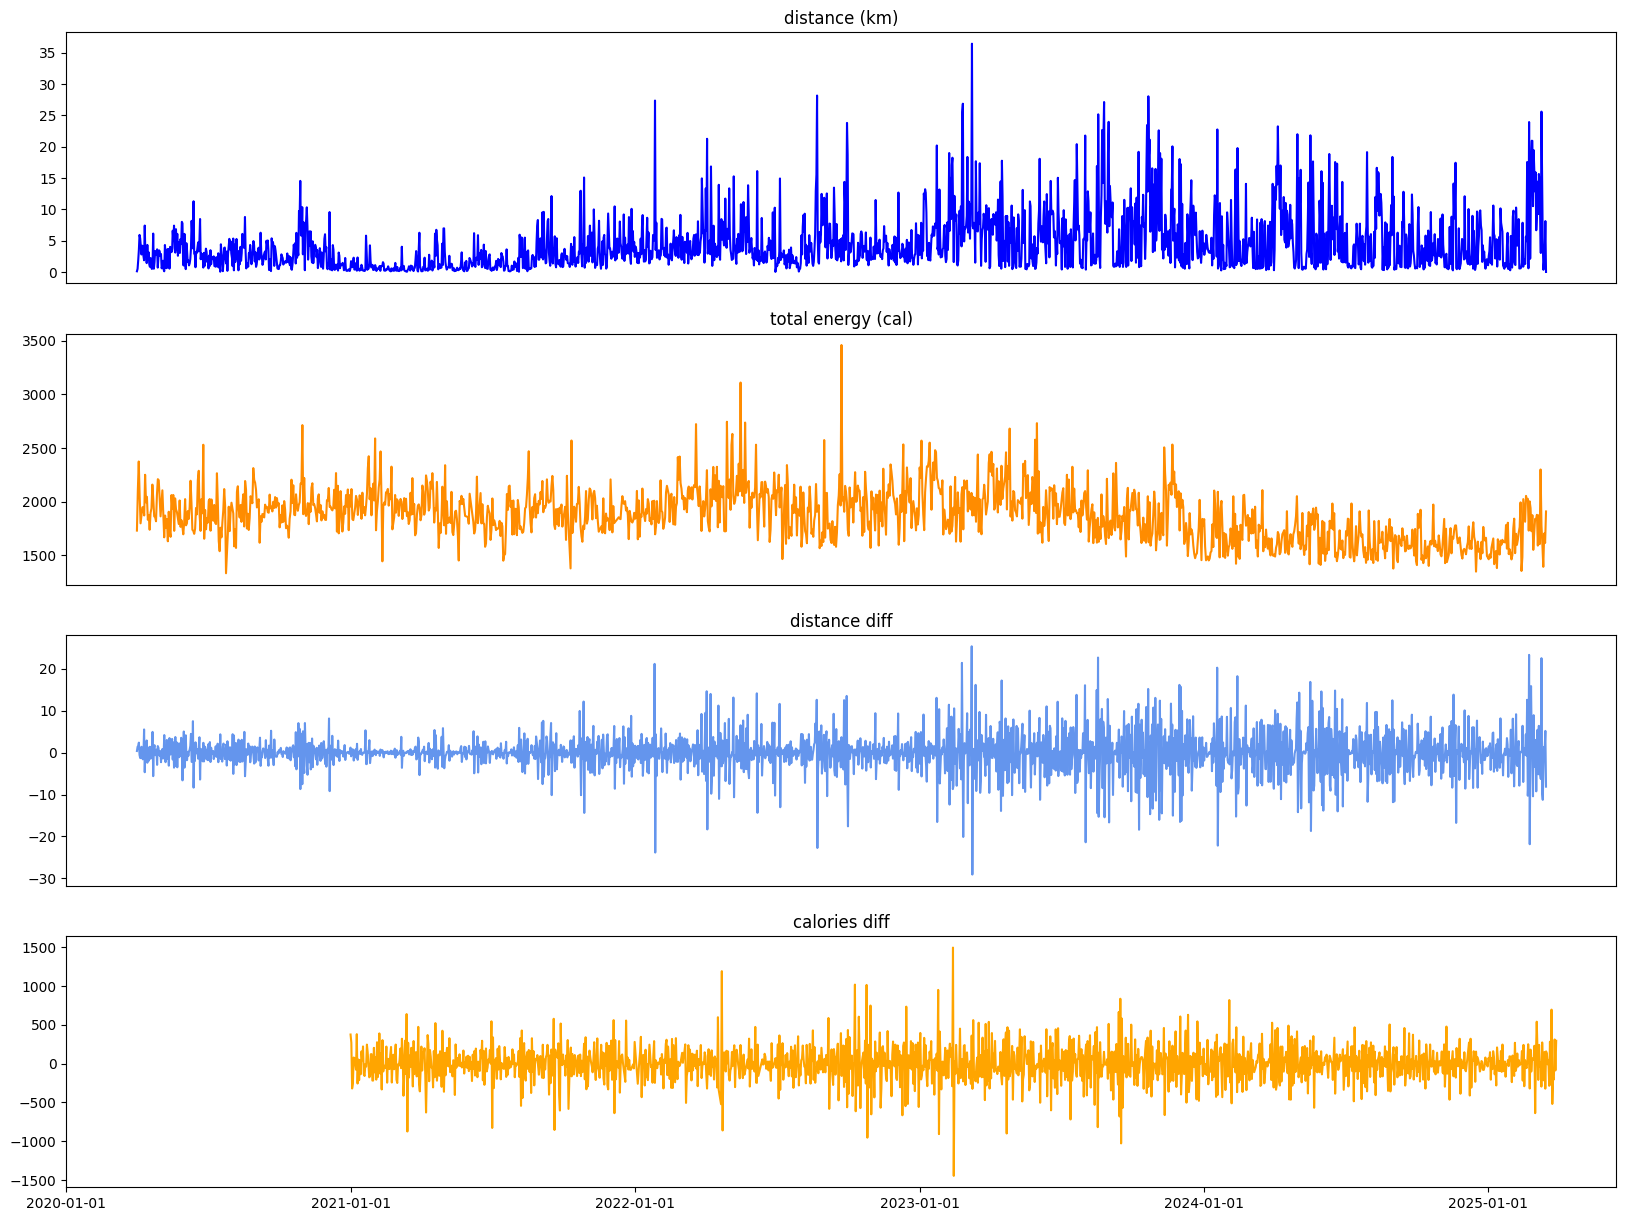

In [23]:
fig, ax = plt.subplots(4, figsize=(20, 15))
ax[0].plot(distance_travelled, color='blue')
ax[0].set_title('distance (km)')
ax[0].set_xticks([])

ax[1].plot(total_cals, color='darkorange')
ax[1].set_title('total energy (cal)')
ax[1].set_xticks([])

distance_diff = distance_travelled.diff()
cals_diff = total_cals.diff()

ax[2].plot(distance_diff, color='cornflowerblue')
ax[2].set_title('distance diff')
ax[2].set_xticks([])

ax[3].plot(cals_diff, color='orange')
ax[3].set_title('calories diff')
ax[3].set_xticks(year_starts)

plt.show()

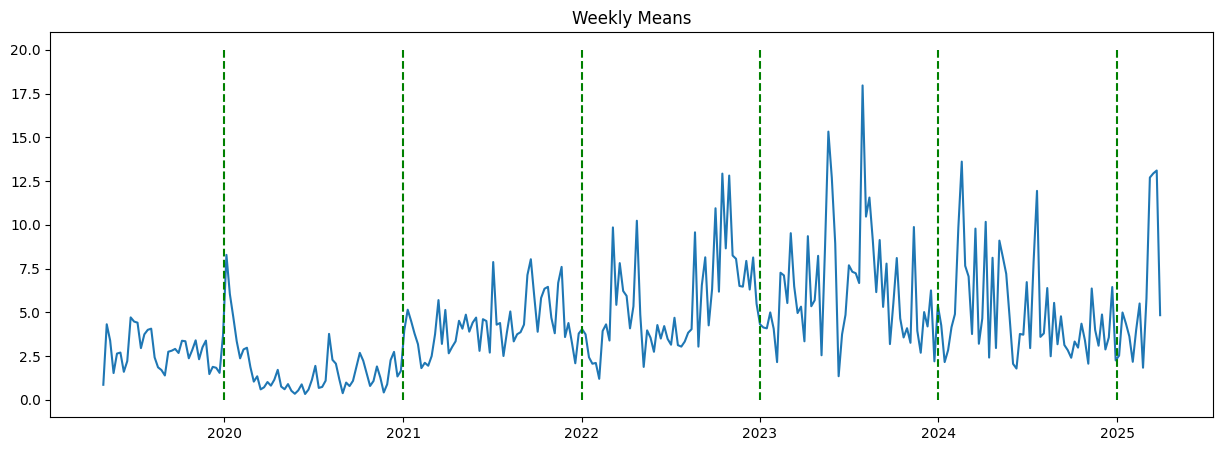

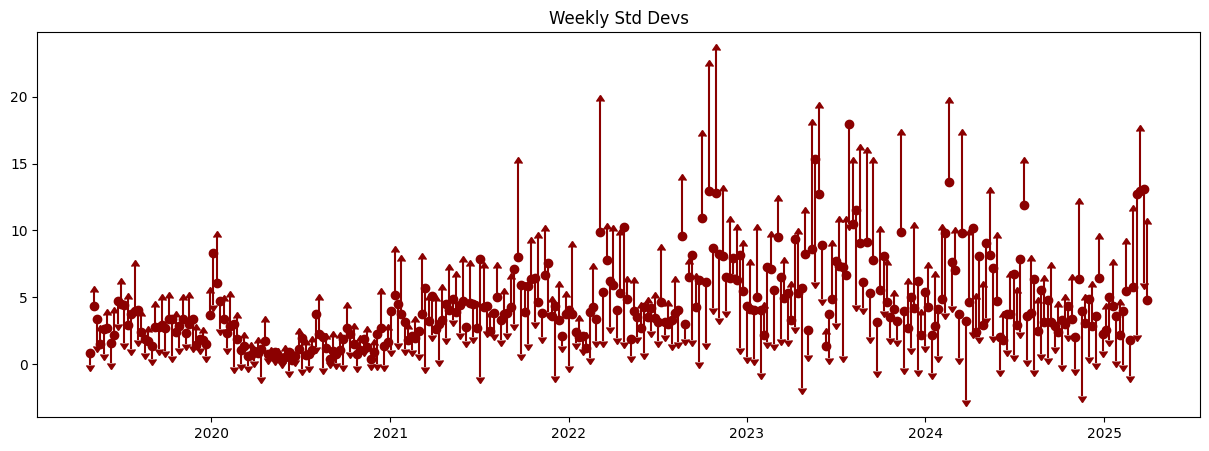

In [76]:
weekly_means = distance_travelled.resample('W').agg(['mean', 'std']).set_axis(['mean_km', 'std_km'], axis=1)
weekly_diffs = weekly_means.diff()

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(weekly_means['mean_km'])
ax.vlines(year_starts, 0, 20, colors='green', linestyles='dashed')
ax.set_title('Weekly Means')
plt.show()


fig, ax = plt.subplots(figsize=(15, 5))
upperlimits = [True, False] * (len(weekly_means)//2)
lowerlimits = [False, True] * (len(weekly_means)//2)
ax.errorbar(weekly_means.index, weekly_means['mean_km'], yerr=weekly_means['std_km'],
            uplims=upperlimits, lolims=lowerlimits, marker='o', linestyle='none',
            color='darkred')
ax.set_title('Weekly Std Devs')
plt.show()

In [ ]:
monthly_means = sum_df['daily_km'].resample('MS').agg(['mean', 'std'])

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(monthly_means.index, monthly_means['mean'], width=20, align='edge', color='lightblue')

upperlimits = [True, False] * (len(monthly_means)//2)
lowerlimits = [False, True] * (len(monthly_means)//2)
ax.errorbar(monthly_means.index + np.timedelta64(10, 'D'), monthly_means['mean'],
            yerr=monthly_means['std'], uplims=upperlimits, lolims=lowerlimits,
            color='darkred', linestyle='none')

ax.vlines(years, 0, 20, colors='green', linestyles='dashed')

ax.set_title('Monthly Means & Std Devs')
plt.show()

In [ ]:
def mode(x):
    return st.mode(x)[0][0]

monthly_means = sum_df['daily_km'].resample('MS').agg(['mean', 'std'])
monthly_df = pd.DataFrame(monthly_means).rename(columns={'mean': 'monthly_km', 'std': 'monthly_std'})
xs = monthly_df.index.to_numpy(dtype='datetime64[D]')
edges = np.append(xs, xs[-1] + np.timedelta64(30, 'D'))

fig, ax = plt.subplots(figsize=(30,10))

ax.stairs(monthly_df['monthly_km'], edges, label='monthly_km', linewidth=1.5, color='blue')

ax.bar(sum_df.index, sum_df['daily_km'], label='daily sums', color='gray', alpha=0.5)

upperlimits = [True, False] * (len(monthly_df)//2)
lowerlimits = [False, True] * (len(monthly_df)//2)
ax.errorbar(monthly_df.index + np.timedelta64(10, 'D'), monthly_df['monthly_km'],
            yerr=monthly_df['monthly_std'], uplims=upperlimits, lolims=lowerlimits,
            color='darkred', linestyle='none')

ax.vlines(years, 0, 35, colors='green', linestyles='dashed', linewidth=2)

ax.set_title('Daily Sums and Monthly Averages')
ax.set_ybound(-0.5, 30)
ax.set_xbound(edges[1], edges[-1])
plt.legend()
plt.show()

In [ ]:
sns_df = sum_df.reset_index()
sns_df['month'] = [np.datetime64(d, 'M') for d in sns_df['date']]
sns_df['diff1'] = sns_df['daily_km'].diff()

fig, ax = plt.subplots(figsize=(30,10))
ax.set_title('Monthly Averages & Std Dev in Seaborn')
sns.lineplot(data=sns_df, x='month', y='daily_km', errorbar='sd', ax=ax)
ax.vlines(years, 0, 18, colors='green', linestyles='dashed', linewidth=2)
plt.show()

fig, ax = plt.subplots(figsize=(30,10))
ax.set_title('Monthly Averages & Std Dev in Seaborn')
sns.lineplot(data=sns_df, x='month', y='diff1', errorbar='sd', ax=ax)
ax.vlines(years, -10, 10, colors='green', linestyles='dashed', linewidth=2)
plt.show()

In [ ]:
def mode(x):
    return st.mode(x)[0][0]

four_years_df = sum_df.loc['2021-01-01':'2024-12-31']
fy_monthly_means = four_years_df['daily_km'].resample('MS').agg(['mean', 'std'])
fy_monthly_df = pd.DataFrame(fy_monthly_means).rename(columns={'mean': 'monthly_km', 'std': 'monthly_std'})
edges = np.append(fy_monthly_df.index.to_numpy(dtype='datetime64[D]'), np.datetime64('2025-01-01', 'D'))

fig, ax = plt.subplots(figsize=(30,10))

ax.stairs(fy_monthly_df['monthly_km'], edges, label='monthly_km', linewidth=1.5, color='blue')

upperlimits = [True, False] * (len(fy_monthly_df)//2)
lowerlimits = [False, True] * (len(fy_monthly_df)//2)
ax.errorbar(fy_monthly_df.index + np.timedelta64(10, 'D'), fy_monthly_df['monthly_km'],
            yerr=fy_monthly_df['monthly_std'], uplims=upperlimits, lolims=lowerlimits,
            color='darkred', linestyle='none')

ax.vlines(years[2:-1], -1, 20, colors='green', linestyles='dashed', linewidth=2)

ax.set_title('Daily Sums and Monthly Averages')
ax.set_ybound(-1, 20)
ax.set_xbound(np.datetime64('2020-12-20'), np.datetime64('2025-01-10'))
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
plot_acf(four_years_df['daily_km'], lags=48, ax=ax)
plt.show()

In [ ]:
def decomp(series, period_name, period=0, months=2):
    if period != 0:
        mult_decomp = seasonal_decompose(series, model='multiplicative', period=period)
    else:
        mult_decomp = seasonal_decompose(series, model='multiplicative')

    res_decomp = seasonal_decompose(mult_decomp.resid.dropna(), model='multiplicative', period=90)

    fig, ax = plt.subplots(5, 1, figsize=(20,20))

    mult_decomp.observed.plot(ax=ax[0], xlabel='')
    ax[1].set_title('Original')

    mult_decomp.trend.plot(ax=ax[1], xlabel='', xticks=[], color='mediumorchid')
    ax[1].set_title('Trends')
    ax[1].legend()

    mult_decomp.resid.plot(ax=ax[2], xlabel='', xticks=[], color='coral', label='residual', linewidth=0.5)
    mult_decomp.seasonal.plot(ax=ax[2], xlabel='', xticks=[], color='darkgreen', label='seasonal')
    ax[2].set_title('Seasonal/Residual')
    ax[2].legend()

    mult_decomp.seasonal.plot(ax=ax[3], xlabel='', color='limegreen')
    bounds = ax[3].get_ybound()
    mult_decomp.resid.plot(ax=ax[3], xlabel='', color='lightcoral', linewidth=0.5)
    mult_decomp.seasonal.plot(ax=ax[3], xlabel='', color='limegreen')
    f_val = np.datetime64('2023-01-01')
    ax[3].set_xbound(f_val, f_val + np.timedelta64(months*4, 'W'))
    ax[3].set_ybound(bounds)
    ax[3].legend()

    res_decomp.trend.plot(ax=ax[4], xlabel='', color='violet')
    ax[4].set_title('2nd Trends')
    ax[4].legend()
    ax[4].legend()

    plt.suptitle(period_name)
    plt.tight_layout()
    plt.show()


decomp(four_years_df['daily_km'], 'Weekly Period', period=7)

f7_weekly = four_years_df['daily_km'].resample('W').mean()
decomp(four_years_df['daily_km'], 'Bi-Weekly Period', period=14)
decomp(f7_weekly, 'Bi-Weekly Period (week avg.)', period=2)

# decomp(four_years_df['daily_km'], 'Monthly Period', period=30, months=4)
# decomp(f7_weekly, 'Monthly Period (week avg.)', period=4, months=4)


In [ ]:
timeseries = four_years_df.copy()
timeseries['day'] = timeseries.index.day
monthly_ts = []

fig, ax = plt.subplots(figsize=[20, 10])
sns_blue = sns.color_palette(as_cmap=True)
for day, ts in timeseries.groupby("day"):
    ts = ts.reset_index()["daily_km"]
    monthly_ts.append(ts)
    ts.plot(alpha=0.1, ax=ax, label='_no_legend_')
    plt.xticks(ticks=np.linspace(0, 50, 30), labels=np.arange(1,31,1))


pd.concat(monthly_ts, axis=1).mean(axis=1).plot(
    ax=ax, color="blue", label="mean", legend=True
)

plt.tight_layout()

In [ ]:
timeseries = four_years_df.copy()
timeseries['day'] = timeseries.index.day


In [ ]:
monthly_ts = []

fig, ax = plt.subplots(figsize=[20, 10])
sns_blue = sns.color_palette(as_cmap=True)
for day, ts in timeseries.groupby("day"):
    ts = ts.reset_index()["daily_km"]
    monthly_ts.append(ts)
    ts.plot(alpha=0.1, ax=ax, label='_no_legend_')
    plt.xticks(ticks=np.linspace(0, 50, 30), labels=np.arange(1,31,1))


pd.concat(monthly_ts, axis=1).mean(axis=1).plot(
    ax=ax, color="blue", label="mean", legend=True
)

plt.tight_layout()